# Εργασία 3

## Β. Ομαδοποίηση τύπων καρκίνου με βάση τα επίπεδα έκφρασης ακολουθιών RNA

Σκοπός της εργασίας είναι η ομαδοποίηση 5 τύπων καρκίνου με βάση τα επίπεδα έκφρασης ακολουθιών RNA. Πρώτα γίνεται μείωση διάστασης δεδομένων βασισμένη σε φασματική ανάλυση γράφου στις 2 διαστάσεις και ακολούθως ομαδοποίηση με spectral clustering.

### 1. Preprocessing

Τα χαρακτηριστικά των δειγμάτων περιέχονται στο αρχείο data.csv και οι ετικέτες τους στο αρχείο labels.csv. Τα αρχεία διαβάζονται και τα δεδομένα τους αποθηκεύονται σε pandas dataframes.

In [1]:
import urllib.request
import pandas as pd
import numpy as np
import tarfile
import os

np.random.seed(0)

folder = 'TCGA-PANCAN-HiSeq-801x20531'
filename = folder + '.tar.gz'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00401/' + filename
data_filename = os.path.join(folder, 'data.csv')
labels_filename = os.path.join(folder, 'labels.csv')

if not os.path.exists(data_filename) or not os.path.exists(labels_filename):
    print('Downloading file...')
    urllib.request.urlretrieve(url, filename)
    print('Done.')
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()
    tar.close()
    
df_x = pd.read_csv(data_filename)
df_y = pd.read_csv(labels_filename)

Παρακάτω φαίνονται τα 5 πρώτα δείγματα.

In [2]:
df_x.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [3]:
df_y.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


In [4]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [5]:
df_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  801 non-null    object
 1   Class       801 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


Βγάζουμε εκτός του dataframe τη στήλη Unnamed γιατί είναι απλώς ένας αύξων αριθμός και δεν προσφέρει κάποια χρήσιμη πληροφορία για την κατηγοριοποίηση.

In [6]:
df_x.drop(df_x.columns[0], axis=1, inplace=True)
df_x.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [7]:
df_y.drop(df_y.columns[0], axis=1, inplace=True)
df_y.head()

,Class
0,PRAD
1,LUAD
2,PRAD
3,PRAD
4,BRCA


Παρακάτω βλέπουμε το ιστόγραμμα των κλάσεων.

<AxesSubplot:>

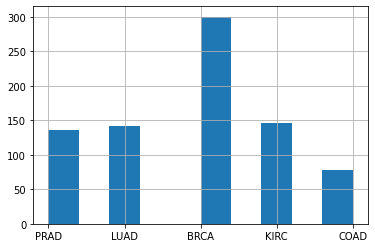

In [8]:
df_y = df_y['Class']
df_y.hist()

To dataset χωρίζεται σε training set (60%) και test set (40%) χρησιμοποιώντας την συνάρτηση StratifiedShuffleSplit η οποία μας εξασφαλίζει οτι η κατανομή στα δυο set θα είναι ίδια ως προς τη μεταβλητή στόχο.

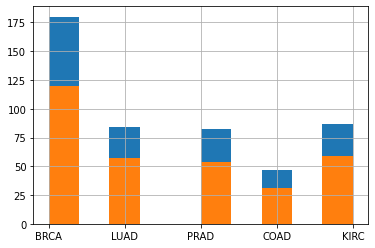

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

for train_index, test_index in sss.split(df_x, df_y):
    df_train_x = df_x.loc[train_index]
    df_train_y = df_y.loc[train_index]
    df_test_x = df_x.loc[test_index]
    df_test_y = df_y.loc[test_index]
   
df_train_y.hist()
df_test_y.hist()
plt.show()

Το training set και το test set αποθηκεύονται σε numpy arrays.

In [10]:
from sklearn.preprocessing import LabelEncoder

x_train = df_train_x.to_numpy()
y_train = df_train_y.to_numpy()
x_test = df_test_x.to_numpy()
y_test = df_test_y.to_numpy()

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (480, 20531)
y_train.shape = (480,)
x_test.shape = (321, 20531)
y_test.shape = (321,)


Γίνεται κανονικοποίηση με αφαίρεση της μέσης τιμής και διαίρεση με την τυπική απόκλιση.

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### 2. Embedding

Ακολουθεί Spectral embedding με rbf affinity το οποίο μετασχηματίζει τα δεδομένα σε χώρο δύο διαστάσεων. Επιλέγεται gamma=1e-4. Αυτή η τιμή μας δίνει ένα ενδιαφέρον αποτελέσμα για την μετέπειτα ομαδοποίηση. Για μεγαλύτερες τιμές υπάρχει πλήρης διαχωρισμός κ πολύ μικρή διασπορά των ομάδων οπότε το πρόβλημα θα μπορούσε να λυθεί εύκολα ακόμα και με k-means.

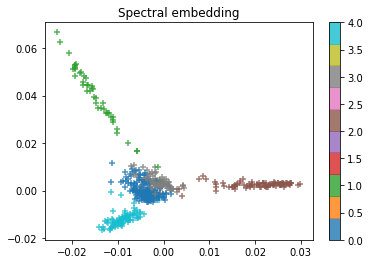

In [12]:
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=2, affinity='rbf', gamma=1e-4)
x_train_embedded = embedding.fit_transform(x_train)
plt.title('Spectral embedding')
plt.scatter(x_train_embedded[:, 0], x_train_embedded[:, 1],
            c=y_train, cmap='tab10', marker='+', alpha=0.8)
plt.colorbar() 
plt.show()

### 3. Algorithms

#### 3.1 MySpectralClustering

Ακολουθεί υλοποίηση Spectral Clustering. Αρχικά χτίζεται ο γράφος ομοιότητας με βάση τους k πλησιέστερους γείτονες. Απο αυτόν προκύπτει ο πίνακας γειτνίασης $G$. Αυτός ο πίνακας δεν είναι συμμετρικός γιατί αν ένα δείγμα Α έχει γείτονα το Β δεν σημαίνει ότι θα ισχύει και το αντίστροφο. Γίνεται συμμετρικός με τον ακόλουθο τύπο $S = \frac{1}{2} (G + G^T)$. Αυτός ο πίνακας είναι ο πίνακας ομοιότητας. Έπειτα πραγματοποιείται ιδιοανάλυση στον unnormalized laplacian matrix $L = D - S$ ή στον normalized laplacian matrix $L_{sym} = D^{-1/2}LD^{-1/2}$. Τα ιδιοδιανύσματα αποτελούν τις στήλες του νέου πίνακα δειγμάτων τα οποία έχουν μετασχηματιστεί σε ένα νέο χώρο. Στο τέλος πραγματοποιείται clustering με k-means.

In [13]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
import scipy
from scipy.linalg import eigh

class MySpectralClustering(object):
    def __init__(self, n_clusters=8, n_components=None, n_neighbors=10,
                 normed=True, random_state=None, n_jobs=None):
        self.n_clusters = n_clusters
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.normed = normed
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.lambdas = None
        
    def set_params(self, **params):
        if not params: return self
        self.n_clusters = params.get('n_clusters', self.n_clusters)
        self.n_components = params.get('n_clusters', self.n_components)
        self.n_neighbors = params.get('n_neighbors', self.n_neighbors)
        self.normed = params.get('normed', self.normed)
        self.random_state = params.get('random_state', self.random_state)
        self.n_jobs = params.get('n_jobs', self.n_jobs)
        return self
    
    def fit_predict(self, X):
        G = kneighbors_graph(X, n_neighbors=self.n_neighbors, n_jobs=self.n_jobs)
        G = G.toarray()
        S = 0.5*(G + G.T)
        L, d = scipy.sparse.csgraph.laplacian(S, normed=self.normed, return_diag=True)
            
        if self.n_components is None:
            self.n_components = self.n_clusters
        
        w, v = eigh(L)
        indices = np.argsort(w)
        w = w[indices]
        v = v[:, indices]
        v = v[:, :self.n_components]
        
        self.lambdas = w
        
        if self.normed:
            v /= np.sqrt(d).reshape(-1, 1)
        
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        labels = kmeans.fit_predict(v)
        
        return labels

### 4. Clustering

Εφαρμόζονται διάφοροι τύποι Spectral Clustering. Γίνεται ομαδοποίηση για n_clusters απο 2 έως 9. Για κάθε τιμή του n_clusters δίνονται διαγράμματα όπου φαίνονται οι διάφορες ομάδες που έχουν σχηματιστεί. Έπειτα δίνονται οι τιμές των Homogeneity, Completeness και V-measure. Η μετρική Homogeneity μας δείχνει κατά πόσο οι ομάδες περιέχουν δεδομένα τα οποία είναι μέλη μίας μόνο κλάσης. Η μετρική Completeness μας δείχνει κατά πόσο όλα τα δείγματα μιας ομάδας είναι μέλη της ίδιας κλάσης. Τέλος η μετρική V-measure είναι ο αρμονικός μέσος των Homogeneity και Completeness. Τα αποτελέσματα της ομαδοποίησης χρησιμοποιούνται για να γίνει κατηγοριοποίηση του test set με Nearest Class Centroid. Ως ετικέτα της ομάδας επιλέγεται η πιο συχνή ετικέτα. Μετά την κατηγοριοποίηση δίνονται οι μετρικές Accuracy, Precision, Recall, F1 και το Confusion Matrix. Επίσης δίνεται διάγραμμα με τις 30 πρώτες ιδιοτιμές και γίνεται εκτίμηση της βέλτιστης τιμής του n_clusters με το eigengap heuristic.

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestCentroid
from sklearn.utils import shuffle
from time import time

all_results = {}

def do_the_clustering(clustering_str, clustering, X, y, verbose=0):
    all_n_clusters = range(2, 10)
    experiments_num = len(all_n_clusters)
    homogeneity = np.zeros(experiments_num)
    completeness = np.zeros(experiments_num)
    v_measure = np.zeros(experiments_num)
    times = np.zeros(experiments_num)
    accuracy = np.zeros(experiments_num)
    recall = np.zeros(experiments_num)
    precision = np.zeros(experiments_num)
    f1 = np.zeros(experiments_num)
    most_frequent_labels = []
    cm = None

    plt.subplots(4, 2, figsize=(15, 25))
    plt.subplots_adjust(hspace=0.3)
    
    for i, n_clusters in enumerate(all_n_clusters):
        clustering.set_params(n_clusters=n_clusters)
        t1 = time()
        y_pred = clustering.fit_predict(X)
        t2 = time()
        times[i] = t2 - t1
        homogeneity[i], completeness[i], v_measure[i] = homogeneity_completeness_v_measure(y, y_pred)        
        plt.subplot(4, 2, i+1)
        plt.title('n_clusters = {}'.format(n_clusters))
        plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='tab10', marker='+', alpha=0.8)
        plt.colorbar()
        if verbose > 0:
            print('n_clusters = {}, time = {:.1f} sec'.format(n_clusters, times[i]))
        
        y_train_new = np.copy(y_pred)       
        for label in range(n_clusters):
            indices = (y_pred == label)
            counts = np.bincount(y.astype(int)[indices])
            val = np.argmax(counts)
            y_train_new[indices] = val
        
        clf = NearestCentroid()
        clf.fit(x_train, y_train_new)
        y_pred_test = clf.predict(x_test)
        accuracy[i] = accuracy_score(y_test, y_pred_test)
        precision[i] = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
        recall[i] = recall_score(y_test, y_pred_test, average='weighted')
        f1[i] = f1_score(y_test, y_pred_test, average='weighted')
        
        if n_clusters == 5:
            cm = confusion_matrix(y_test, y_pred_test)
 
    plt.show()
    
    lambdas = clustering.lambdas[:20] if hasattr(clustering, 'lambdas') else None 
    
    results = {
        'all_n_clusters': all_n_clusters,
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure,
        'times': times,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'times': times,
        'cm': cm,
        'most_frequent_labels': most_frequent_labels,
        'lambdas': lambdas
    }
    
    all_results[clustering_str] = results
        
    return results

In [15]:
def plot_clustering_results(results):
    all_n_clusters = results['all_n_clusters']
    homogeneity = results['homogeneity']
    completeness = results['completeness']
    v_measure = results['v_measure']
    times = results['times']
    
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.4)
    
    plt.subplot(1, 2, 1)
    plt.title('Clustering scores')
    plt.plot(all_n_clusters, homogeneity, label='Homogeneity')
    plt.plot(all_n_clusters, completeness, label='Completeness')
    plt.plot(all_n_clusters, v_measure, label='V-Measure')
    plt.ylabel('Score')
    plt.xlabel('n_clusters')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('Clustering time')
    plt.plot(all_n_clusters, times)
    plt.ylabel('Time (sec)')
    plt.xlabel('n_clusters')
    plt.show()

In [16]:
import seaborn as sns

def plot_classification_results(results):
    all_n_clusters = results['all_n_clusters']
    accuracy = results['accuracy']
    precision = results['precision']
    recall = results['recall']
    f1 = results['f1']
    cm = results['cm']
    
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(1, 2, 1)
    plt.title('Classification scores')
    plt.plot(all_n_clusters, accuracy, label='Accuracy')
    plt.plot(all_n_clusters, precision, label='Precision')
    plt.plot(all_n_clusters, recall, label='Recall')
    plt.plot(all_n_clusters, f1, label='F1')
    plt.ylabel('Score')
    plt.xlabel('n_clusters')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('Confusion matrix for n_clusters = 5')
    sns.heatmap(cm, cmap="Oranges", annot=True)
    plt.show()

In [17]:
def plot_eigvals(results):
    lambdas = results['lambdas']
    plt.title('Eigenvalues')
    plt.scatter(range(1, len(lambdas)+1), lambdas, marker='+')
    plt.show()

In [18]:
from IPython.display import display, HTML
import pandas as pd

def display_scores(results):
    all_n_clusters = results['all_n_clusters']
    homogeneity = results['homogeneity']
    completeness = results['completeness']
    v_measure = results['v_measure']
    accuracy = results['accuracy']
    precision = results['precision']
    recall = results['recall']
    f1 = results['f1']
    times = results['times']
    
    df = pd.DataFrame(list(zip(all_n_clusters, homogeneity, completeness, v_measure,
                           accuracy, precision, recall, f1, times)),
                  columns=('n_clusters', 'Homogeneity', 'Completeness', 'V-Measure',
                           'Accuracy', 'Precision', 'Recall', 'F1', 'Clustering Time (sec)'))
    display(HTML(df.to_html(index=False)))

In [19]:
def display_final_scores(all_results, n_clusters):
    homogeneity, completeness, v_measure = [], [], []
    accuracy, precision, recall, f1 = [], [], [], []
    times = []

    clustering_strs = [
        'My Unnormalized Spectral Clustering',
        'My Normalized Spectral Clustering',
        'Normalized Spectral Clustering',
    ]
    
    index = n_clusters-2

    for clustering_str in clustering_strs:
        results = all_results[clustering_str]
        homogeneity.append(results['homogeneity'][index])
        completeness.append(results['completeness'][index])
        v_measure.append(results['v_measure'][index])
        accuracy.append(results['accuracy'][index])
        precision.append(results['precision'][index])
        recall.append(results['recall'][index])
        f1.append(results['f1'][index])
        times.append(results['times'][index])

    df = pd.DataFrame(list(zip(clustering_strs, homogeneity, completeness, v_measure,
                           accuracy, precision, recall, f1, times)),
                  columns=('Clustering', 'Homogeneity', 'Completeness', 'V-Measure',
                           'Accuracy', 'Precision', 'Recall', 'F1', 'Clustering Time (sec)'))
    display(HTML(df.to_html(index=False)))

#### 4.1 My Unnormalized Spectral Clustering

Πραγματοποιείται ομαδοποίηση Spectral Clustering χρησιμοποιώντας τον unnormalized laplacian matrix $L = D - S$.

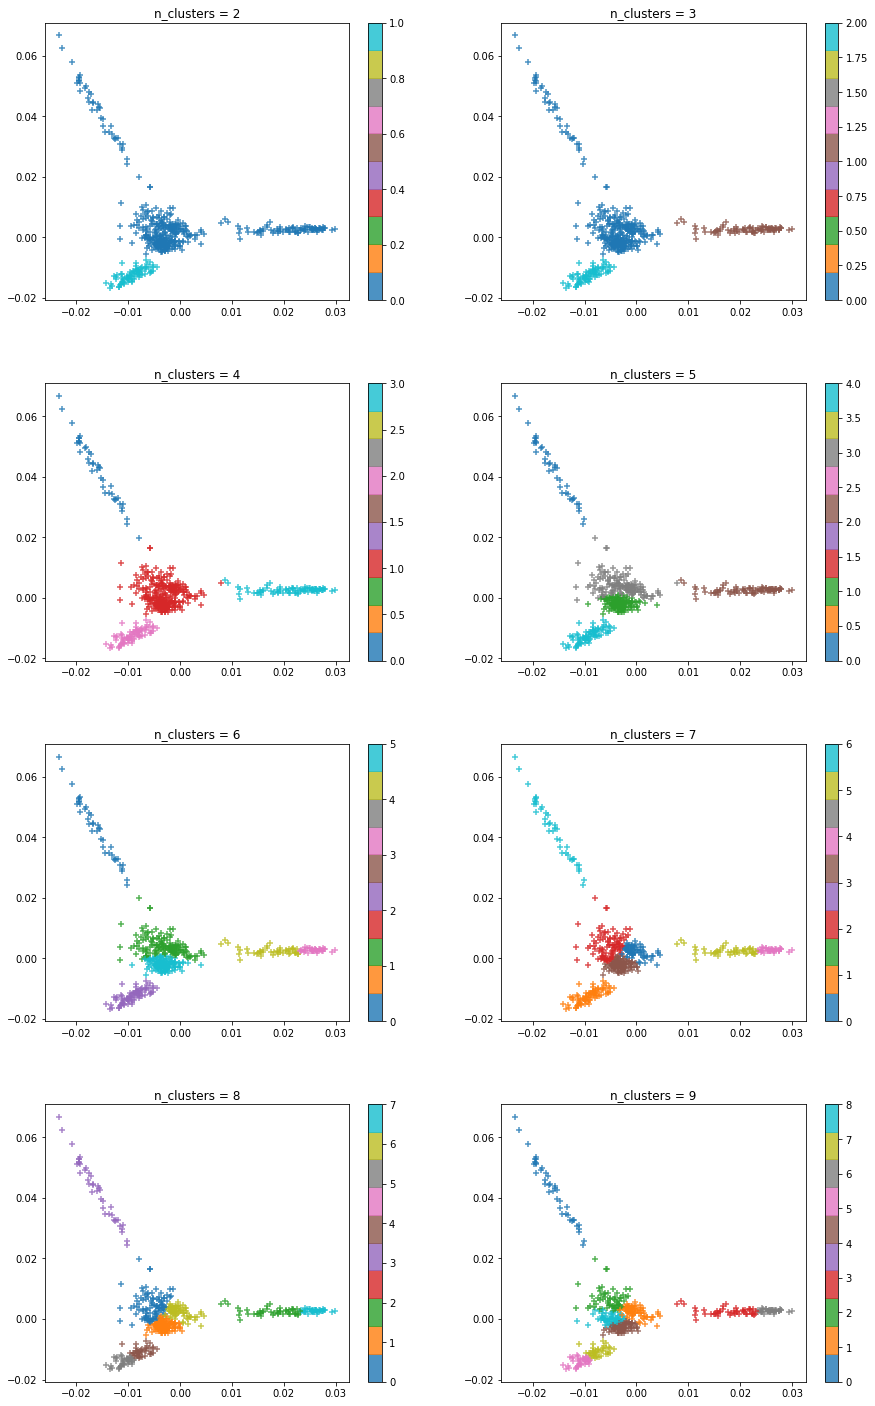

In [20]:
clustering = MySpectralClustering(n_neighbors=20, normed=False, random_state=0, n_jobs=-1)

results = do_the_clustering('My Unnormalized Spectral Clustering', clustering, x_train_embedded, y_train)

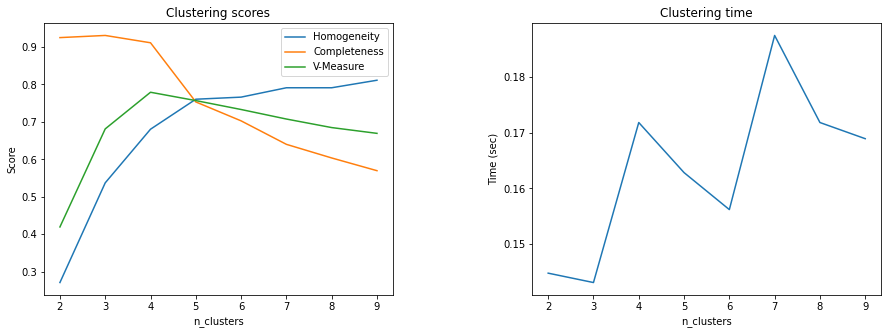

In [21]:
plot_clustering_results(results)

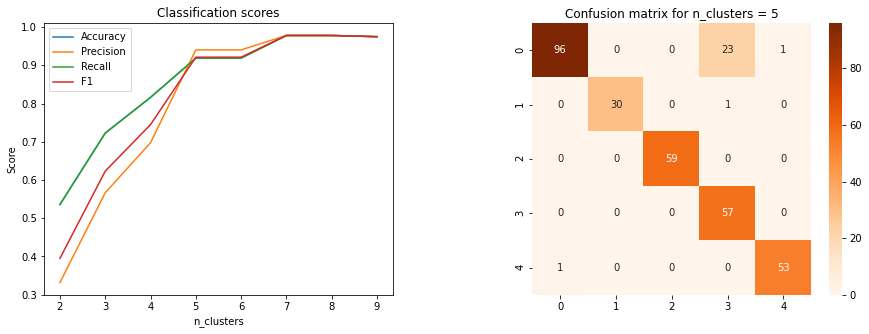

In [22]:
plot_classification_results(results)

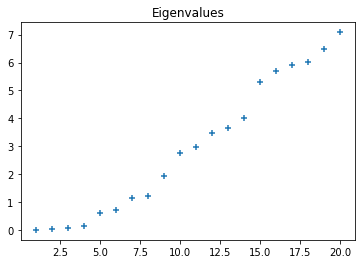

In [23]:
plot_eigvals(results)

In [24]:
display_scores(results)

n_clusters,Homogeneity,Completeness,V-Measure,Accuracy,Precision,Recall,F1,Clustering Time (sec)
2,0.271531,0.924972,0.419821,0.535826,0.331723,0.535826,0.395011,0.144809
3,0.537502,0.930723,0.681456,0.722741,0.566665,0.722741,0.623157,0.143126
4,0.680572,0.911189,0.779174,0.816199,0.697504,0.816199,0.744983,0.171835
5,0.760578,0.753357,0.756951,0.919003,0.940417,0.919003,0.921352,0.162848
6,0.766169,0.702880,0.733161,0.919003,0.940417,0.919003,0.921352,0.156213
7,0.791166,0.640224,0.707736,0.978193,0.978271,0.978193,0.978108,0.187455
8,0.791166,0.603884,0.684954,0.978193,0.978271,0.978193,0.978108,0.171834
9,0.811243,0.569952,0.669521,0.975078,0.975115,0.975078,0.975044,0.168934


#### 4.2 My Normalized Spectral Clustering

Πραγματοποιείται ομαδοποίηση Spectral Clustering χρησιμοποιώντας τον normalized laplacian matrix $L_{sym} = D^{-1/2}LD^{-1/2}$.

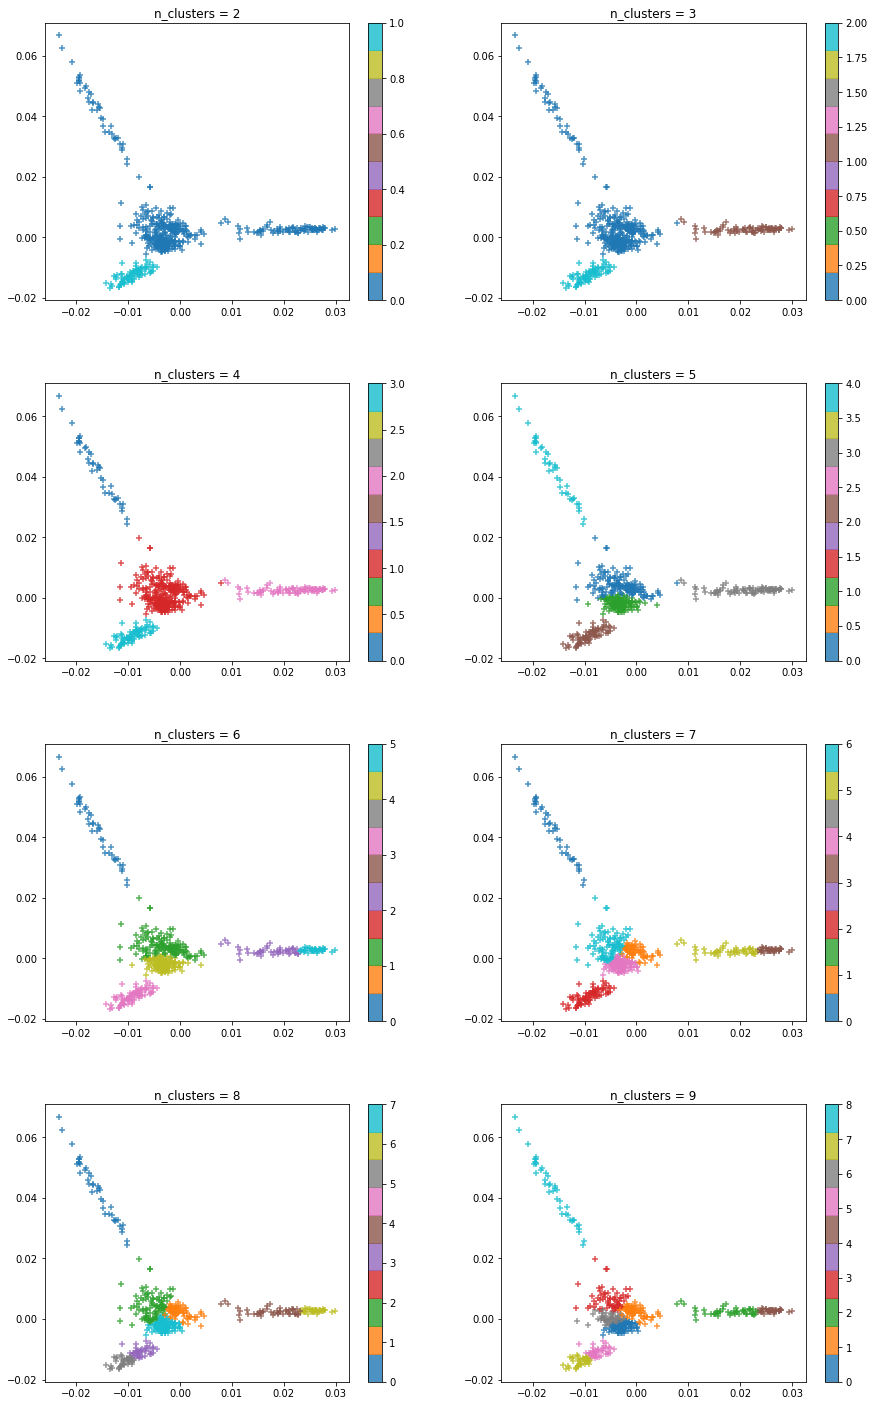

In [25]:
clustering = MySpectralClustering(n_neighbors=20, normed=True, random_state=0, n_jobs=-1)

results = do_the_clustering('My Normalized Spectral Clustering', clustering, x_train_embedded, y_train)

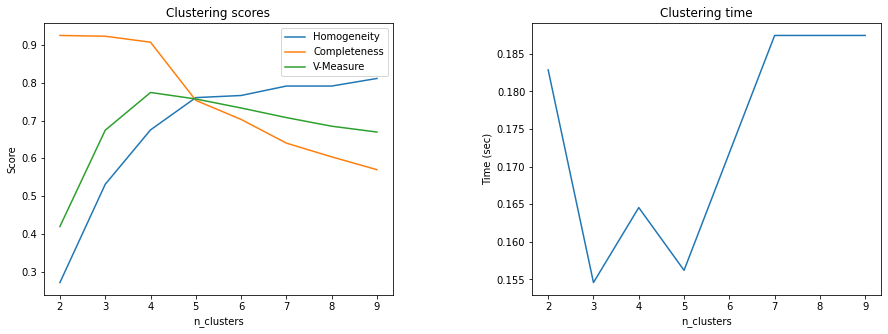

In [26]:
plot_clustering_results(results)

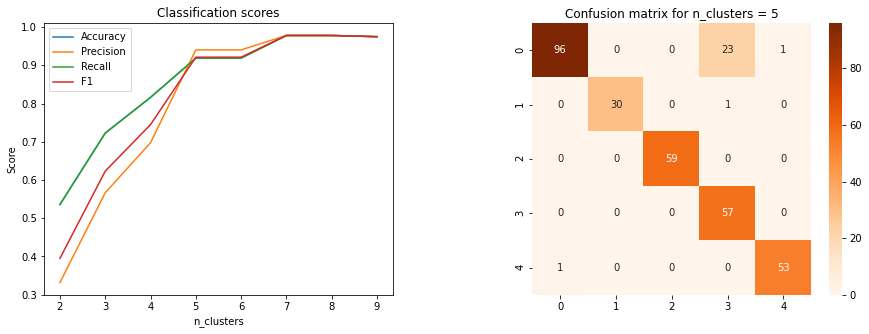

In [27]:
plot_classification_results(results)

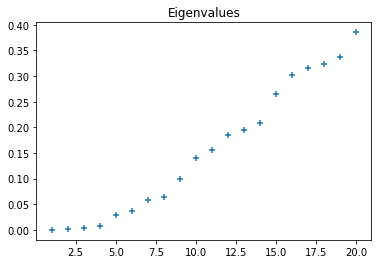

In [28]:
plot_eigvals(results)

In [29]:
display_scores(results)

n_clusters,Homogeneity,Completeness,V-Measure,Accuracy,Precision,Recall,F1,Clustering Time (sec)
2,0.271531,0.924972,0.419821,0.535826,0.331723,0.535826,0.395011,0.182872
3,0.531281,0.922899,0.674358,0.722741,0.566665,0.722741,0.623157,0.154587
4,0.675166,0.907132,0.774146,0.816199,0.697504,0.816199,0.744983,0.164560
5,0.760578,0.753357,0.756951,0.919003,0.940417,0.919003,0.921352,0.156214
6,0.766169,0.702880,0.733161,0.919003,0.940417,0.919003,0.921352,0.171839
7,0.791166,0.640224,0.707736,0.978193,0.978271,0.978193,0.978108,0.187455
8,0.791166,0.603884,0.684954,0.978193,0.978271,0.978193,0.978108,0.187456
9,0.811243,0.569952,0.669521,0.975078,0.975115,0.975078,0.975044,0.187456


#### 4.3 Normalized Spectral Clustering

Πραγματοποιείται ομαδοποίηση Spectral Clustering με τον αλγόριθμο sklearn.cluster.SpectralClustering ο οποίος χρησιμοποιεί τον normalized laplacian matrix $L_{sym} = D^{-1/2}LD^{-1/2}$.

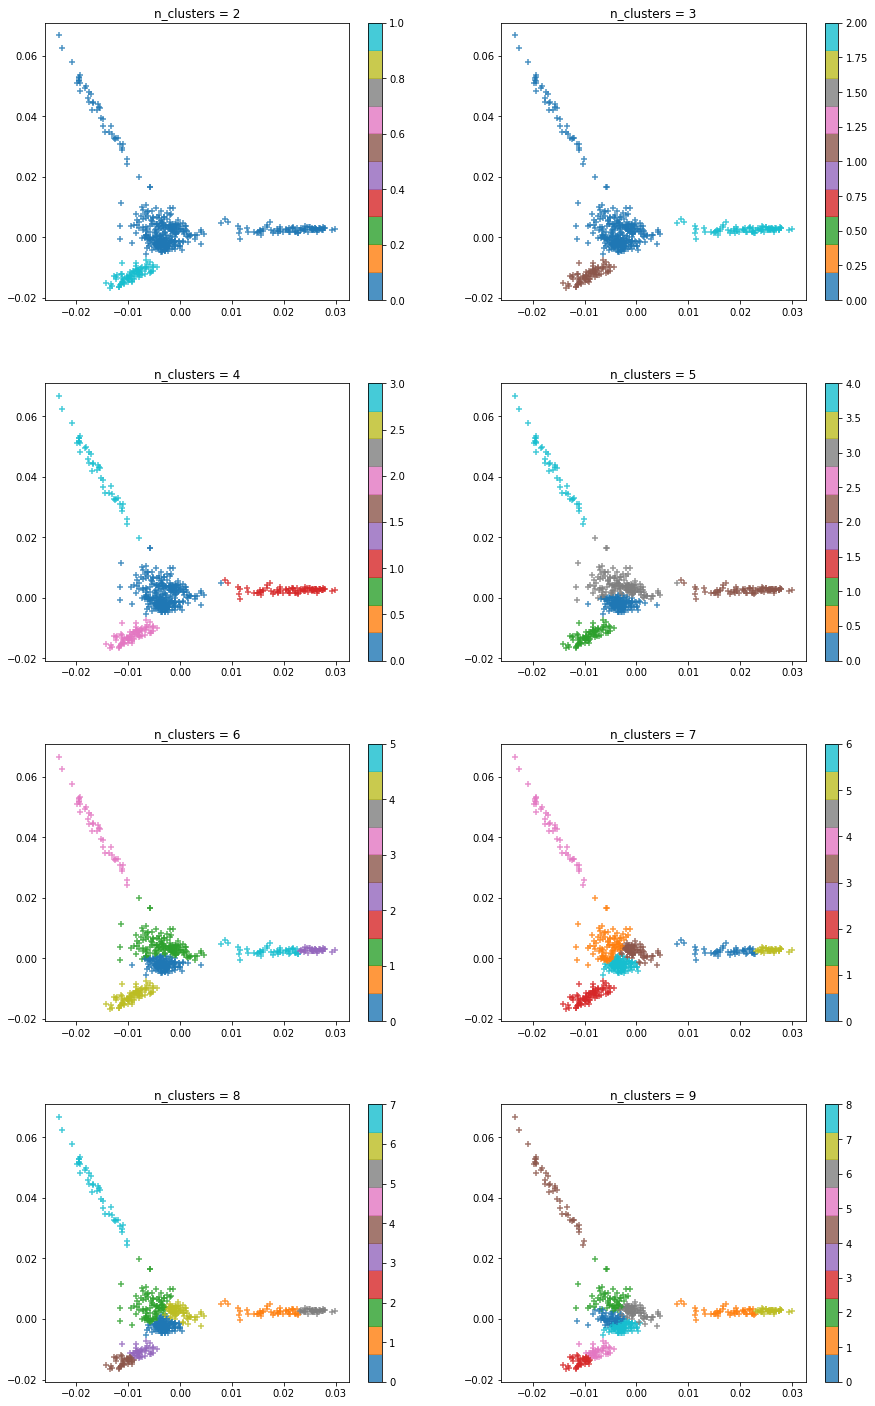

In [30]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=20, random_state=0, n_jobs=-1)

results = do_the_clustering('Normalized Spectral Clustering', clustering, x_train_embedded, y_train)

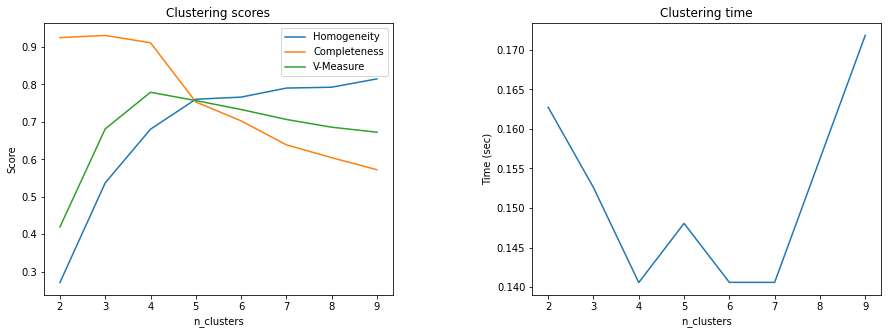

In [31]:
plot_clustering_results(results)

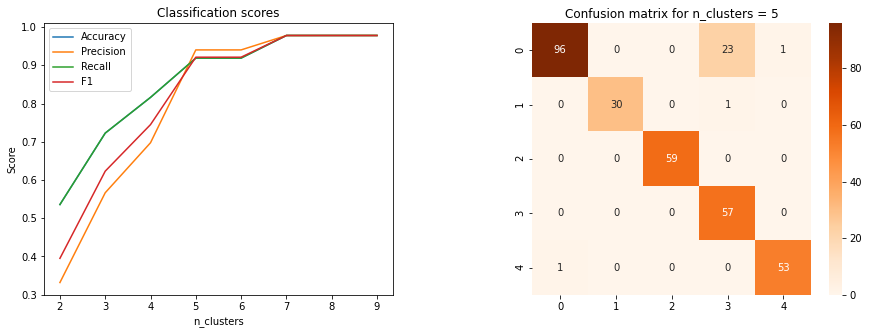

In [32]:
plot_classification_results(results)

In [33]:
display_scores(results)

n_clusters,Homogeneity,Completeness,V-Measure,Accuracy,Precision,Recall,F1,Clustering Time (sec)
2,0.271531,0.924972,0.419821,0.535826,0.331723,0.535826,0.395011,0.162745
3,0.537502,0.930723,0.681456,0.722741,0.566665,0.722741,0.623157,0.152592
4,0.680572,0.911189,0.779174,0.816199,0.697504,0.816199,0.744983,0.140569
5,0.760578,0.753357,0.756951,0.919003,0.940417,0.919003,0.921352,0.148054
6,0.766169,0.702880,0.733161,0.919003,0.940417,0.919003,0.921352,0.140592
7,0.790331,0.638868,0.706573,0.978193,0.978103,0.978193,0.978129,0.140589
8,0.792610,0.604606,0.685960,0.978193,0.978271,0.978193,0.978108,0.156213
9,0.814882,0.572538,0.672544,0.978193,0.978271,0.978193,0.978108,0.171834


### 5. Σύγκριση αποτελεσμάτων για n_clusters = 5

Ακολουθεί συνοπτικός πίνακας των clustering και classification scores για n_clusters = 5.

In [34]:
display_final_scores(all_results, n_clusters=5)

Clustering,Homogeneity,Completeness,V-Measure,Accuracy,Precision,Recall,F1,Clustering Time (sec)
My Unnormalized Spectral Clustering,0.760578,0.753357,0.756951,0.919003,0.940417,0.919003,0.921352,0.162848
My Normalized Spectral Clustering,0.760578,0.753357,0.756951,0.919003,0.940417,0.919003,0.921352,0.156214
Normalized Spectral Clustering,0.760578,0.753357,0.756951,0.919003,0.940417,0.919003,0.921352,0.148054


Όλοι οι αλγόριθμοι έχουν παρόμοια αποτελέσματα. Το πρώτο κενό παρατηρείται μεταξύ της 4ης και 5ης ιδιοτιμής, οπότε η βέλτιστη τιμή του n_clusters με βάση τις ιδιοτιμές είναι ίση με 4. Το V-measure έχει τη μέγιστη τιμή για n_clusters=4 αλλά το Homogeneity είναι μικρό. Αντίθετα για n_clusters=5 όλα τα clustering scores έχουν καλή τιμή. Τα classification scores πιάνουν μια αρκετά μεγάλη τιμή για n_clusters=5 ενώ για περισσότερα clusters δεν αυξάνονται ιδιαίτερα. Για n_clusters=5 υπάρχει σύγχιση μεταξύ της κλάσης 0 (PRAD) και 3 (KIRC).